In [1]:
import pyvista as pv
pv.start_xvfb()  

w_size = (1000, 1000)
zoom = 1.2

import numpy as np
from data.dataset import BudjBimWallMeshDataset

bbw_set = BudjBimWallMeshDataset(root='data/BudjBimWall', split='test', load_feature='all')

idx = 121

mesh = pv.read(bbw_set.mesh_list[idx])

face_v = bbw_set[idx].pos.cpu().numpy()

face_adj = bbw_set[idx].edge_index.cpu().t().numpy()
face_adj = np.hstack((np.full((face_adj.shape[0], 1), 2), face_adj), dtype=face_adj.dtype)

f_normal = bbw_set[idx].x[:, 0:3].cpu().numpy()
f_rgba = bbw_set[idx].rgba.cpu().numpy()
f_mask = bbw_set[idx].y.cpu().numpy()

## Point Clouds

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


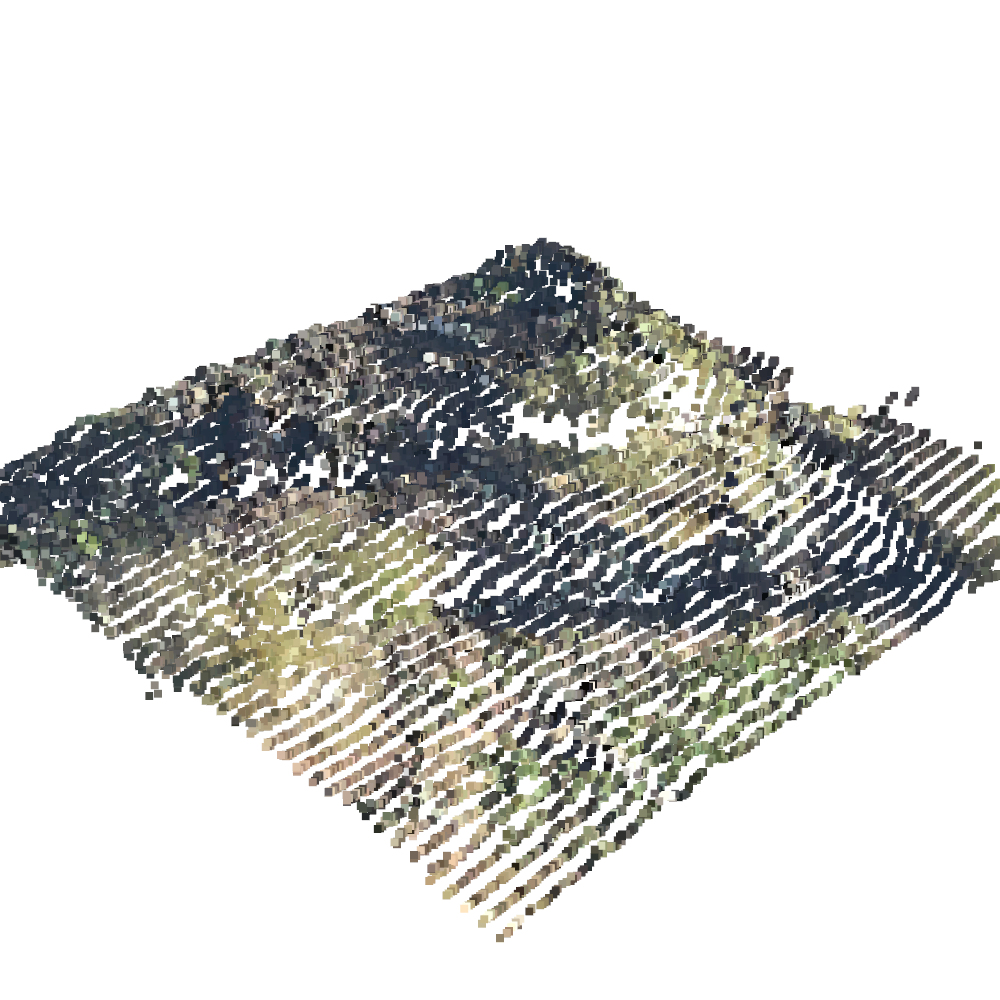

In [2]:
from plyfile import PlyData

pcd_file = 'data/BudjBimWall/pcd/area2/e570330_n5786710_epsg7854.ply'

pcd_data = PlyData.read(pcd_file)
pcd_rgb = np.vstack((np.asarray(pcd_data.elements[0].data['red']),
                     np.asarray(pcd_data.elements[0].data['green']),
                     np.asarray(pcd_data.elements[0].data['blue'])))
pcd_rgb = np.swapaxes(pcd_rgb, 0, 1) 
pcd_rgb = pcd_rgb / 255.0
                    

pcd = pv.read(pcd_file)
pcd.point_data['RGB'] = pcd_rgb 

pcd.plot(scalars='RGB',
         rgb=True,
         cpos='iso', 
         window_size=w_size, 
         zoom=zoom,
         render_points_as_spheres=False, 
         point_size=8, 
         line_width=1,
         show_axes=False,
         show_scalar_bar=False)

## Mesh

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


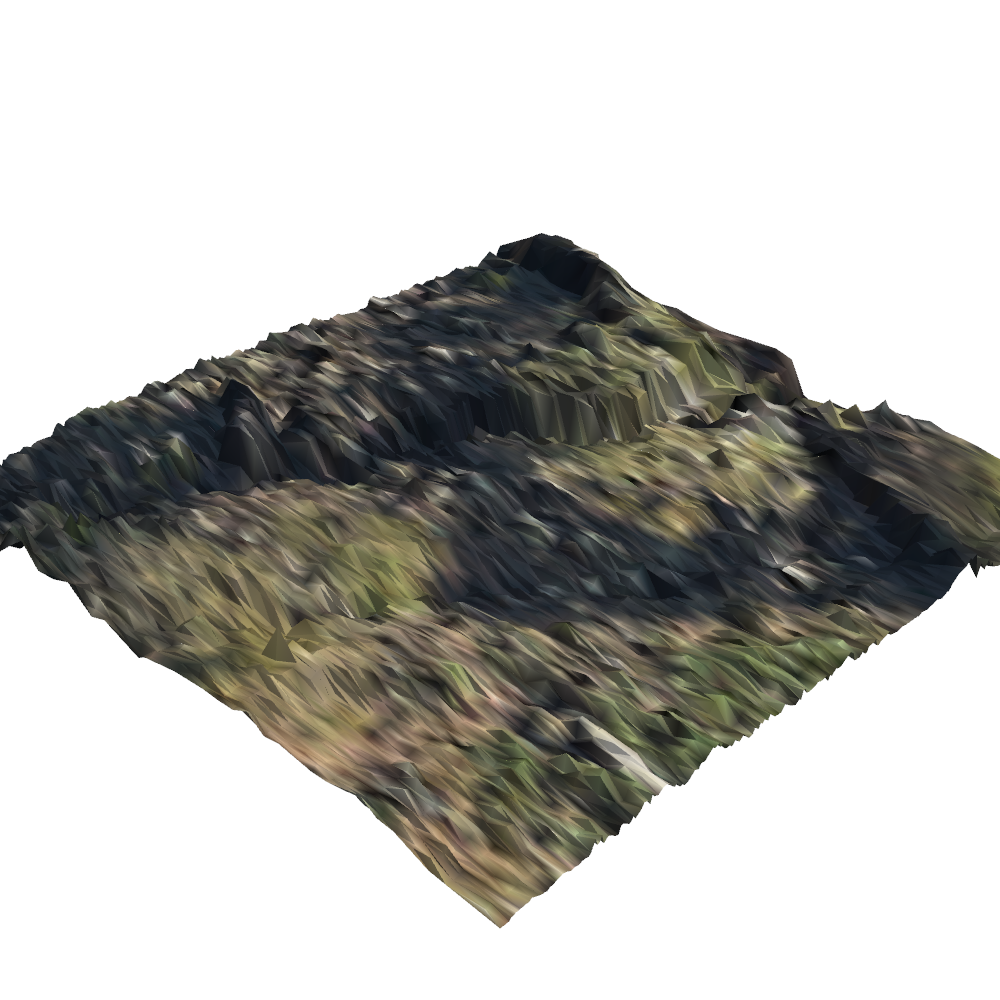

In [3]:
mesh.cell_data['RGBA'] = f_rgba
mesh.cell_data.active_scalars_name = 'RGBA'
mesh.plot(scalars='RGBA', 
          rgb=True,
          cpos='iso', 
          window_size=w_size,
          zoom=zoom,
          show_axes=False,
          show_scalar_bar=False)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


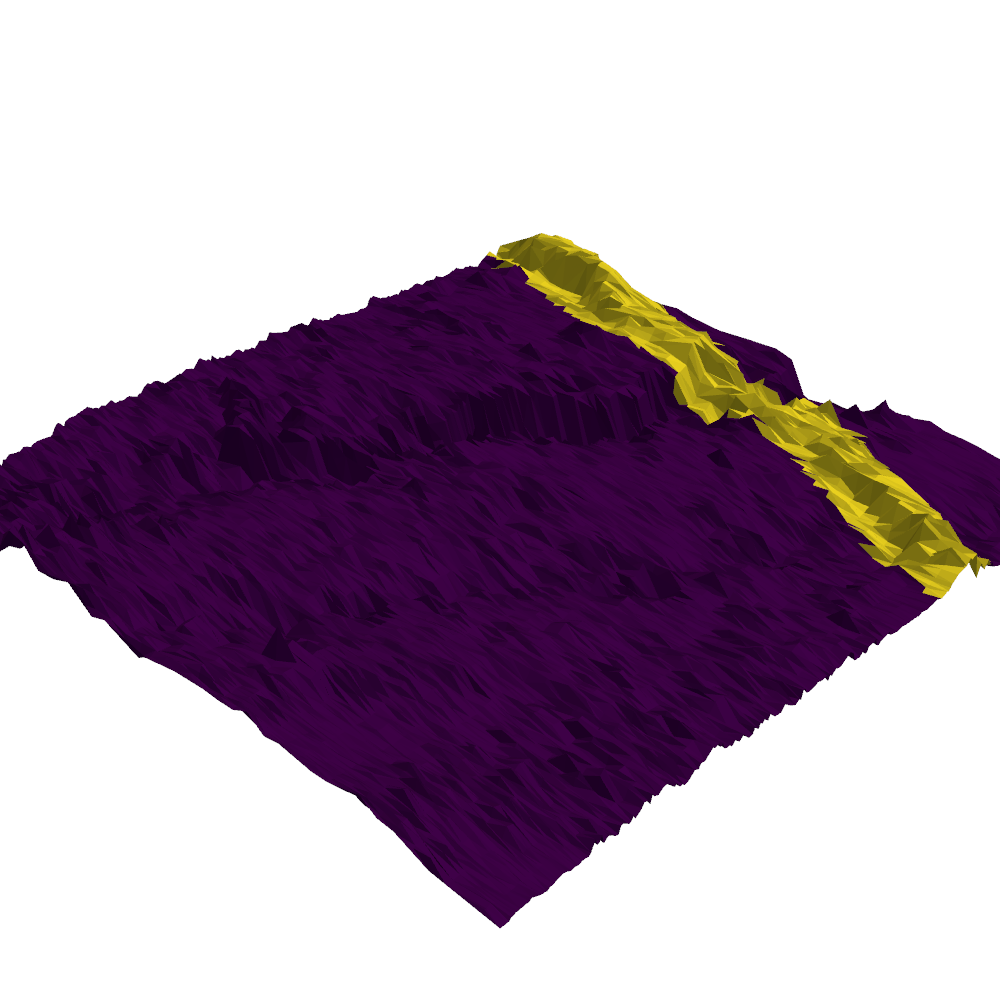

In [4]:
mesh.cell_data['Mask'] = f_mask
mesh.cell_data.active_scalars_name = 'Mask'
mesh.plot(scalars='Mask', 
          cpos='iso', 
          window_size=w_size,
          zoom=zoom,
          show_axes=False,
          show_scalar_bar=False)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


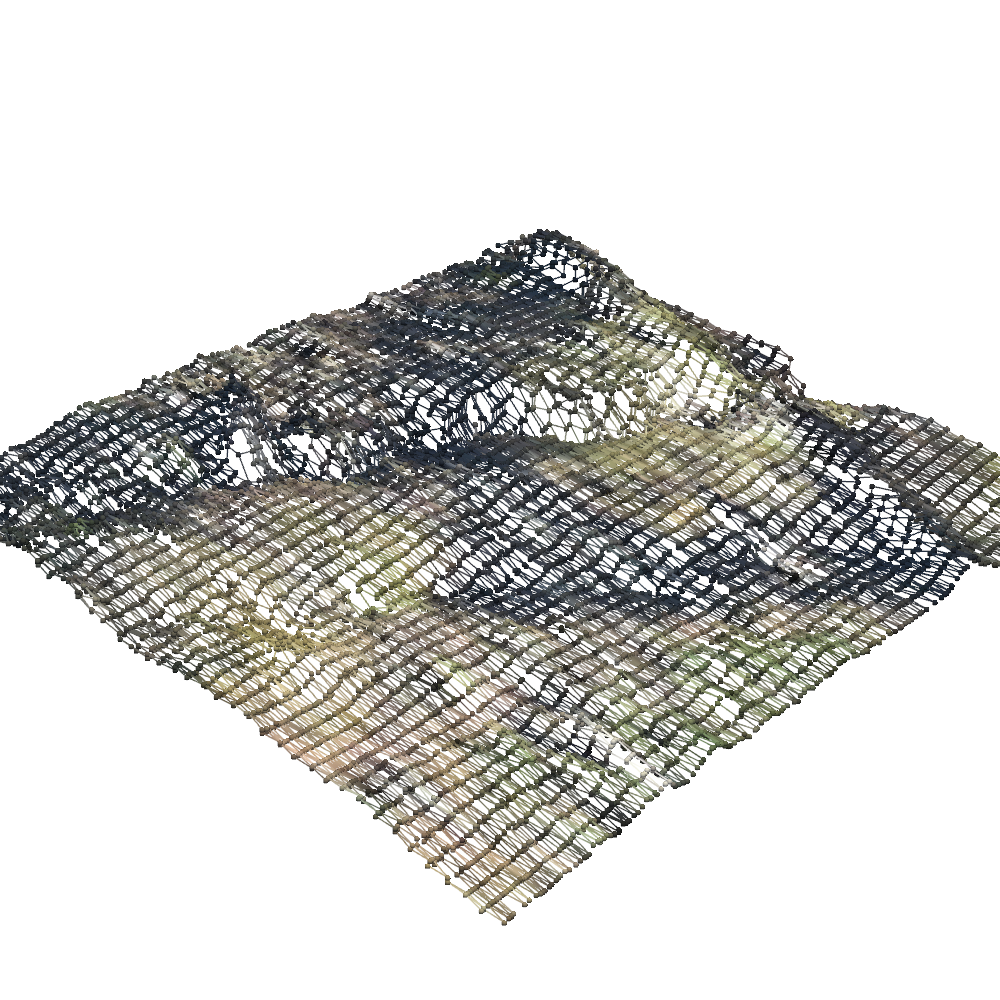

In [5]:
face_pcd = pv.PolyData(face_v)
face_pcd.lines = face_adj
face_pcd.point_data['RGBA'] = f_rgba
face_pcd.point_data.active_scalars_name = 'RGBA'
face_pcd.plot(scalars='RGBA', 
              rgb=True, 
              cpos='iso', 
              window_size=w_size, 
              zoom=zoom,
              render_points_as_spheres=True, 
              point_size=6, 
              line_width=1.5,
              show_axes=False)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


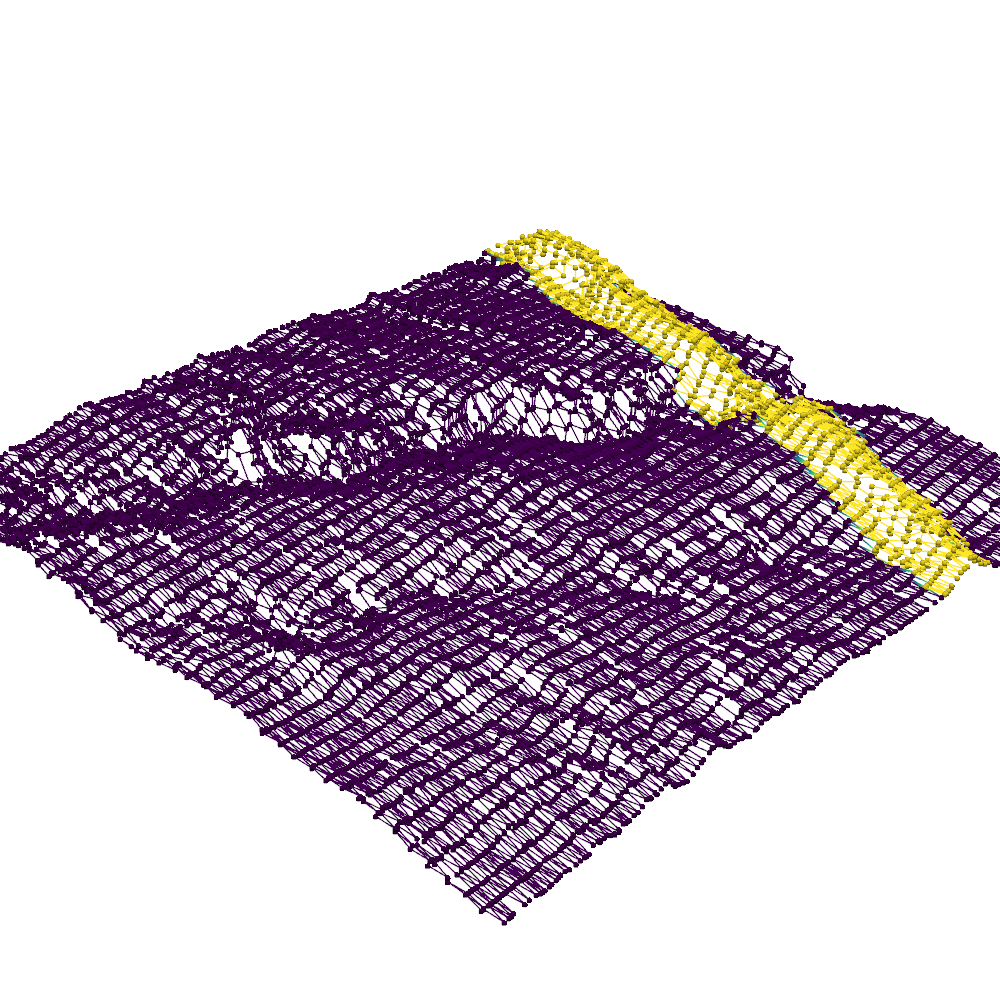

In [6]:
face_pcd.point_data['Mask'] = f_mask
face_pcd.point_data.active_scalars_name = 'Mask'
face_pcd.plot(scalars='Mask', 
              cpos='iso', 
              window_size=w_size, 
              zoom=zoom,
              render_points_as_spheres=True, 
              point_size=6, 
              line_width=1.5,
              show_axes=False,
              show_scalar_bar=False)

## Surface Normal

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


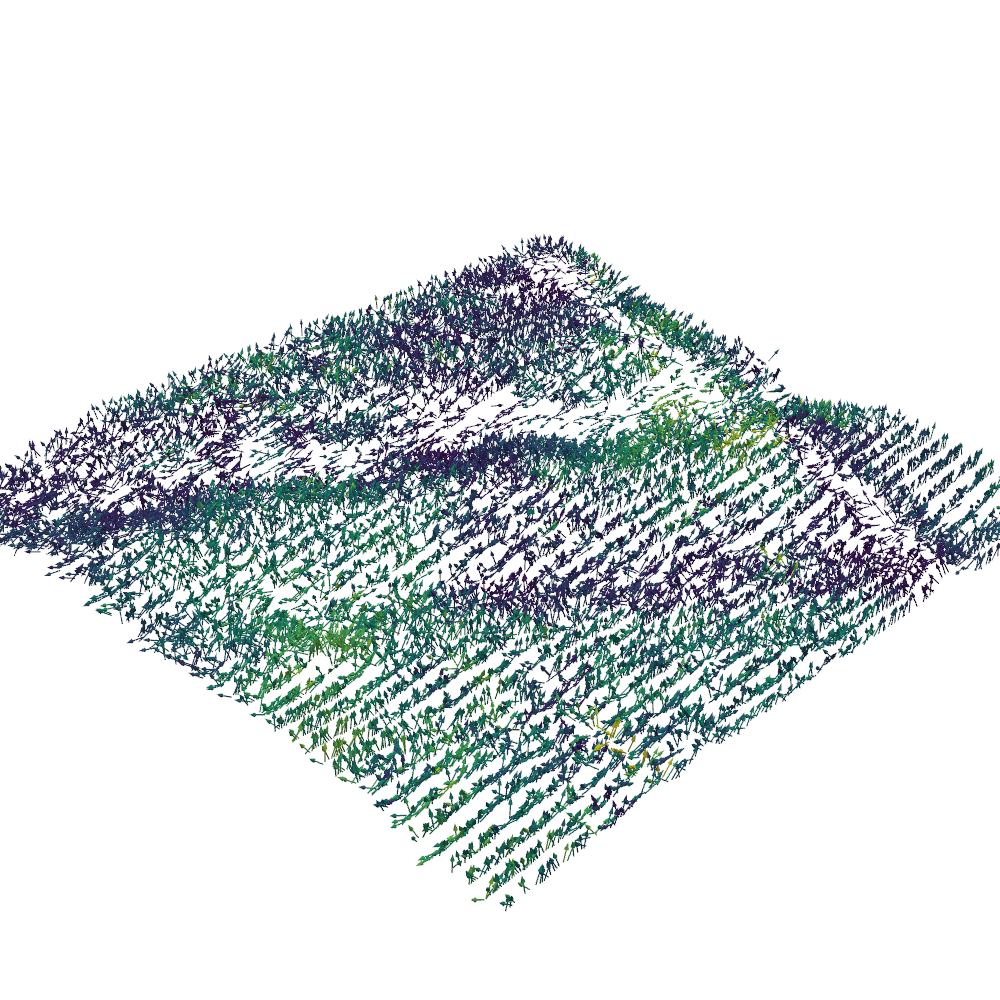

In [7]:
face_pcd.point_data['Normal'] = f_normal
arrows = face_pcd.glyph(orient='Normal', scale=False, factor=0.05, tolerance=0.001)
arrows.plot(cpos='iso', 
            window_size=w_size,
            zoom=zoom,
            show_axes=False,
            show_scalar_bar=False)

## Prediction

In [8]:

import yaml
import torch

from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex

from train.trainer import Trainer
from model.net import LMSegNet
from model.PointNet2.net import PointNet2
from model.RandlaNet.net import RandlaNet
from model.DeeperGCN.net import DeeperGCN
from model.GraphUNet.net import GraphUNet
from model.PointTransformer.net import PointTransformer


with open('cfg/bbw/bbw_lmseg_feature.yaml', 'r') as f:
    cfg = yaml.safe_load(f) 
    model = LMSegNet(cfg['in_channels'], 
                     cfg['out_channels'],
                     cfg['hid_channels'], 
                     cfg['num_convs'], 
                     cfg['pool_factors'], 
                     cfg['num_nbrs'],
                     cfg['num_block'],
                     cfg['alpha'], 
                     cfg['beta'])


# with open('cfg/bbw/bbw_lmseg_hsv.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = LMSegNet(cfg['in_channels'], 
#                      cfg['out_channels'],
#                      cfg['hid_channels'], 
#                      cfg['num_convs'], 
#                      cfg['pool_factors'], 
#                      cfg['num_nbrs'],
#                      cfg['num_block'],
#                      cfg['alpha'], 
#                      cfg['beta'])


# with open('cfg/bbw/bbw_lmseg_normals.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = LMSegNet(cfg['in_channels'], 
#                      cfg['out_channels'],
#                      cfg['hid_channels'], 
#                      cfg['num_convs'], 
#                      cfg['pool_factors'], 
#                      cfg['num_nbrs'],
#                      cfg['num_block'],
#                      cfg['alpha'], 
#                      cfg['beta'])


# with open('cfg/bbw/bbw_randlanet_feature.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = RandlaNet(cfg['in_channels'], 
#                       cfg['out_channels'],
#                       cfg['decimation'],
#                       cfg['num_nbrs'])


# with open('cfg/bbw/bbw_pointnet2_feature.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = PointNet2(cfg['in_channels'], 
#                       cfg['out_channels'],
#                       cfg['pool_ratio'],
#                       cfg['num_nbrs'])


# with open('cfg/bbw/bbw_ptr_feature.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = PointTransformer(cfg['in_channels'], 
#                              cfg['out_channels'], 
#                              cfg['hid_channels'], 
#                              cfg['pool_ratio'], 
#                              cfg['num_nbrs'])
    
    
# with open('cfg/bbw/bbw_deepergcn_feature.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = DeeperGCN(cfg['in_channels'], 
#                       cfg['out_channels'],
#                       cfg['hid_channels'], 
#                       cfg['num_layers'])


# with open('cfg/bbw/bbw_gunet_feature.yaml', 'r') as f:
#     cfg = yaml.safe_load(f)    
#     model = GraphUNet(cfg['in_channels'], 
#                       cfg['hid_channels'], 
#                       cfg['out_channels'], 
#                       cfg['depth'],
#                       cfg['pool_ratios'],
#                       cfg['sum_res'],
#                       cfg['act'])
    

trainer = Trainer(cfg=cfg) 
model = trainer.load_weights(model, f"epoch{cfg['epoch']}")

## Evaluation

In [9]:
test_loader = DataLoader(bbw_set, 
                         batch_size=cfg['batch'], 
                         shuffle=False, 
                         num_workers=cfg['workers'])

metric_dict = {
    'f1': BinaryF1Score(), 
    'mIoU': BinaryJaccardIndex()
    }

cm = trainer.eval(model, 
                  test_loader, 
                  metric=metric_dict, 
                  ckpt=f"epoch{cfg['epoch']}",
                  verbose=True)

f1: 0.7479787468910217
mIoU: 0.5974169969558716


In [10]:
y = model(Batch.from_data_list([bbw_set[idx]]).to(cfg['device']))['y']
pred = torch.nn.functional.sigmoid(y).detach().cpu().numpy()

thred = 0.5
pred[pred > thred] = 1
pred[pred <= thred] = 0

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


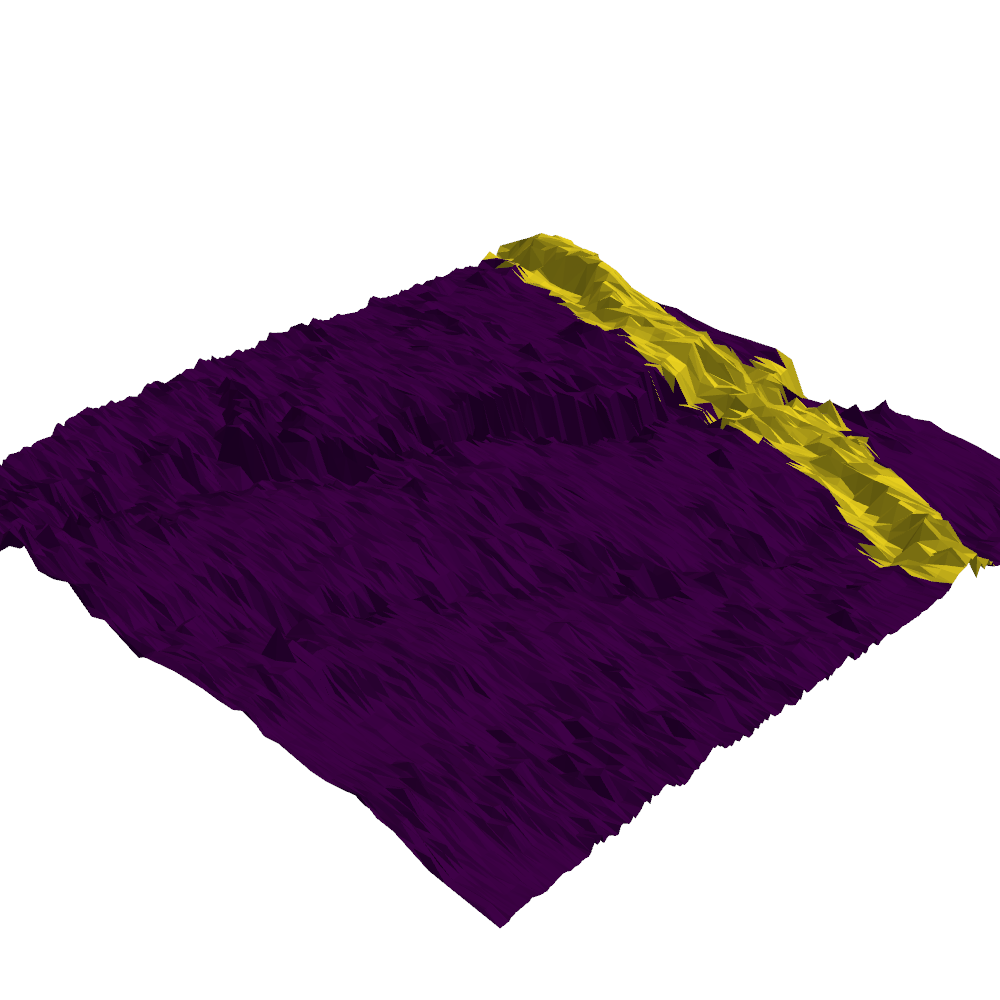

In [11]:
mesh.cell_data['Pred'] = pred
mesh.cell_data.active_scalars_name = 'Pred'
mesh.plot(scalars='Pred', 
          cpos='iso', 
          window_size=w_size,           
          zoom=zoom,
          show_axes=False,
          show_scalar_bar=False)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


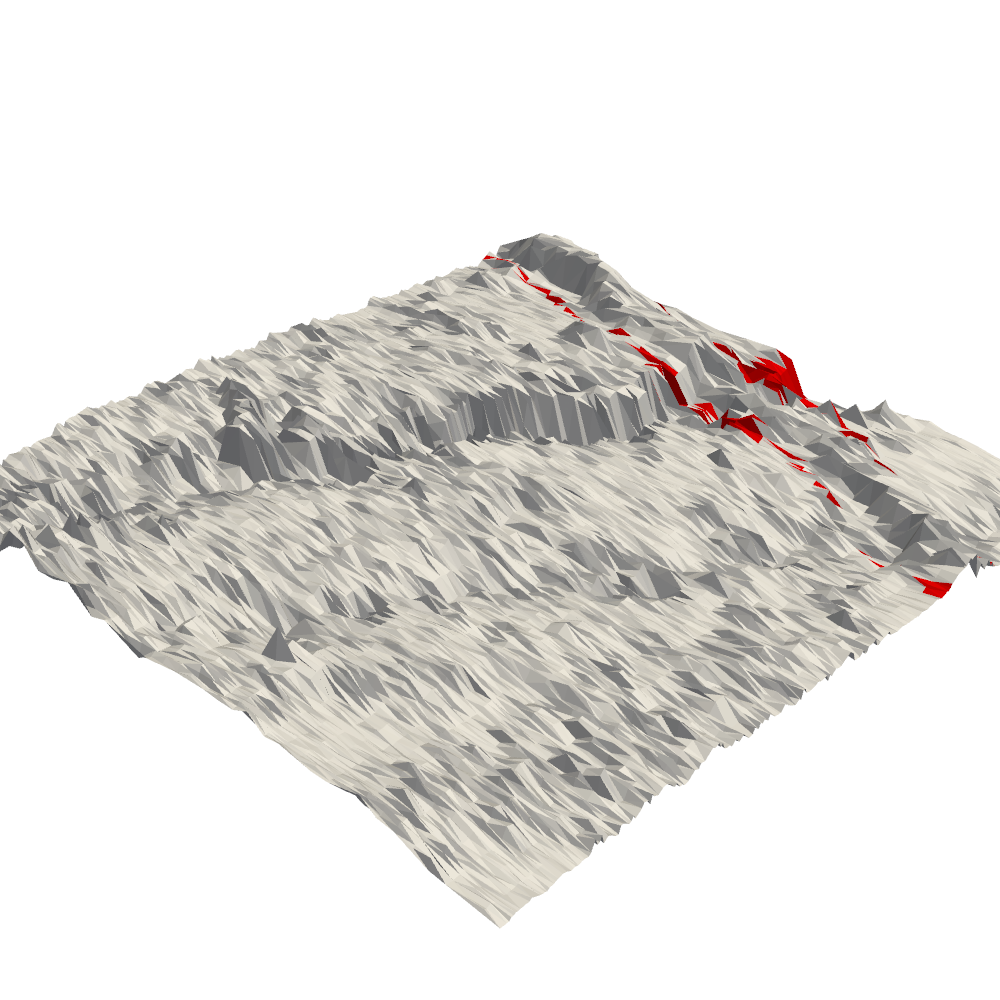

In [12]:
error = (pred != f_mask)

mesh.cell_data['Error'] = error
mesh.cell_data.active_scalars_name = 'Error'
mesh.plot(scalars='Error', 
          cpos='iso', 
          cmap=['white', 'red'],
          window_size=w_size,           
          zoom=zoom,
          show_axes=False,
          show_scalar_bar=False)

In [13]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


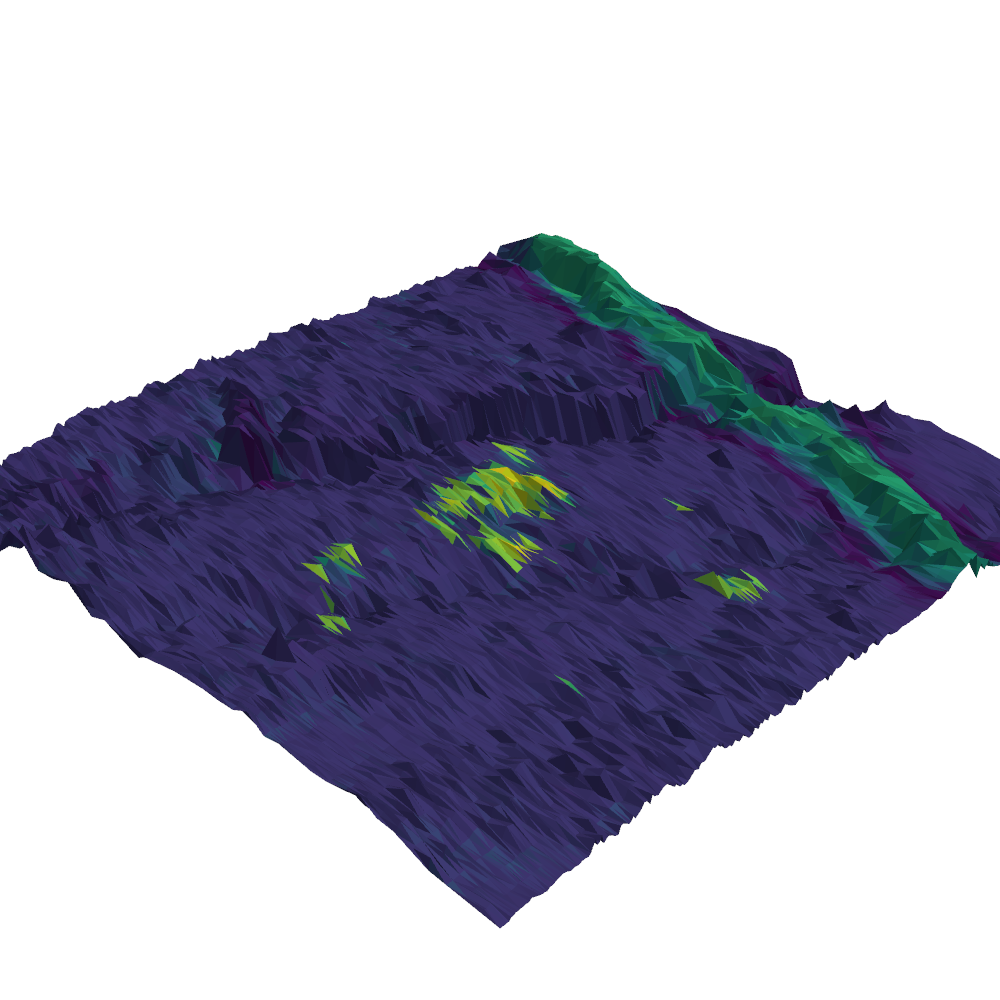

In [14]:
model.Dec.up_convs[3].register_forward_hook(get_activation('out'))
model(Batch.from_data_list([bbw_set[idx]]).to(cfg['device']))['y']
out = activation['out'].sigmoid().sum(1).detach().cpu().numpy()

mesh.cell_data['Out'] = out
mesh.cell_data.active_scalars_name = 'Out'
mesh.plot(scalars='Out', 
          cpos='iso', 
          window_size=w_size,           
          zoom=zoom,
          show_axes=False,
          show_scalar_bar=False)

## Gen Aggr

In [15]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="darkgrid", 
              palette="pastel")
sns.set_theme(rc={"figure.dpi": 250, 
                  'savefig.dpi': 250,
                  "axes.spines.right": False, 
                  "axes.spines.top": False})

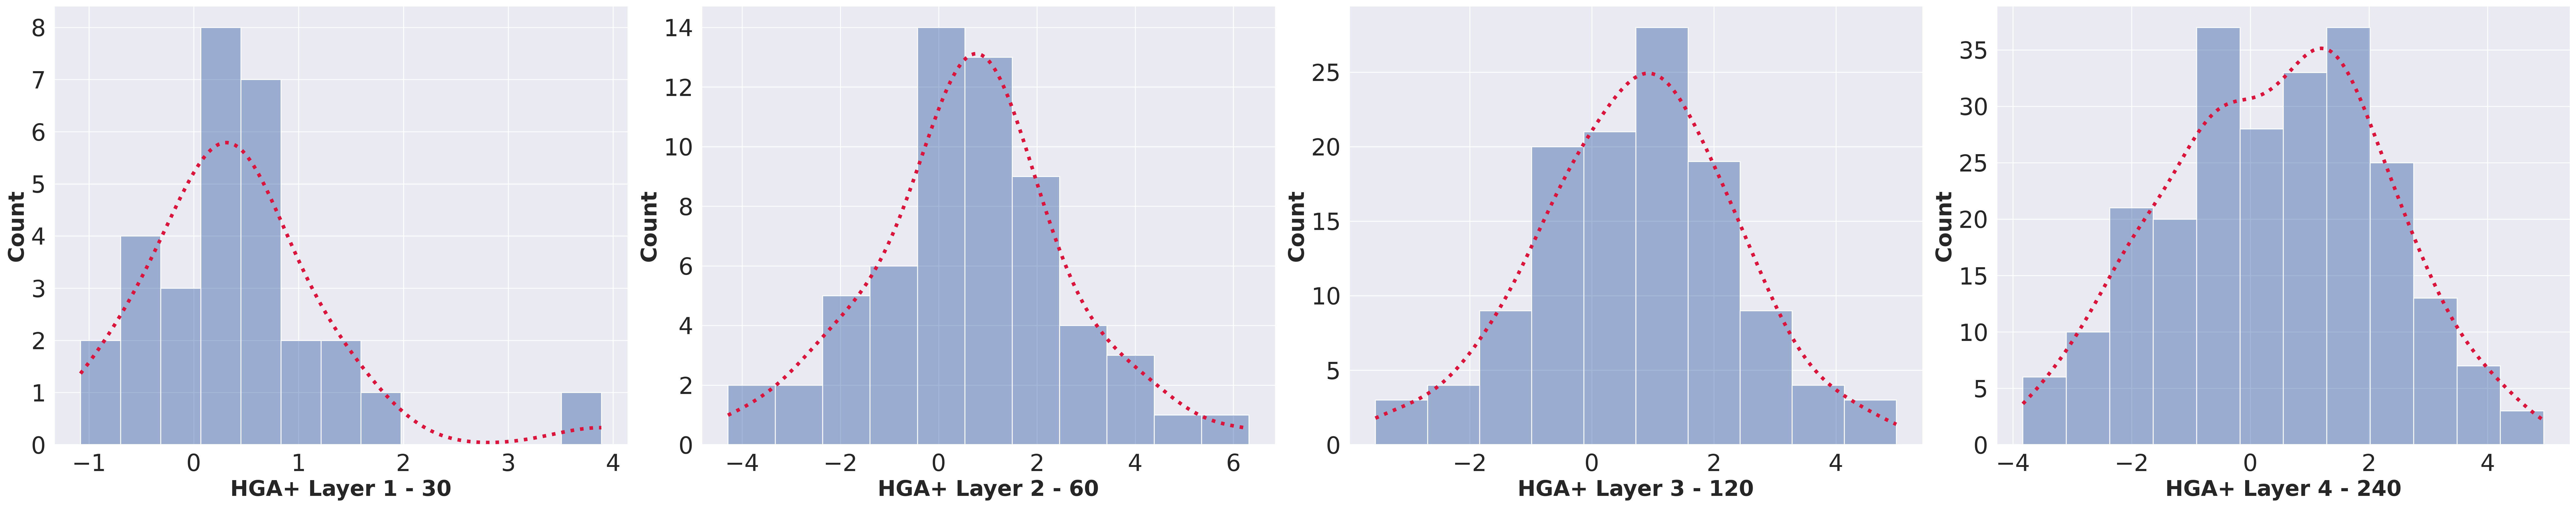

In [16]:
HGA_t = []

for name, param in model.named_parameters():
  if name in ['Enc.down_convs_hier.0.gen_aggr.t',
              'Enc.down_convs_hier.1.gen_aggr.t',
              'Enc.down_convs_hier.2.gen_aggr.t',
              'Enc.down_convs_hier.3.gen_aggr.t']:
    HGA_t.append(param.detach().cpu().numpy())
    

f, axes = plt.subplots(1, len(HGA_t), figsize=(40, 8))
layer = 1
    
for t, ax in zip(HGA_t, axes.flatten()):    
    hist = sns.histplot(t.reshape(-1, 1), legend=False, ax=ax, kde=True, 
                        line_kws={'lw': 4, 'ls': ':'})
    hist.lines[0].set_color('crimson')
    hist.tick_params(labelsize=26)
    
    hist.set_xlabel(f'HGA+ Layer {layer} - {t.shape[0]}', weight='bold', fontsize=24)
    hist.set_ylabel('Count', weight='bold', fontsize=24)
    
    layer += 1
    
plt.tight_layout()

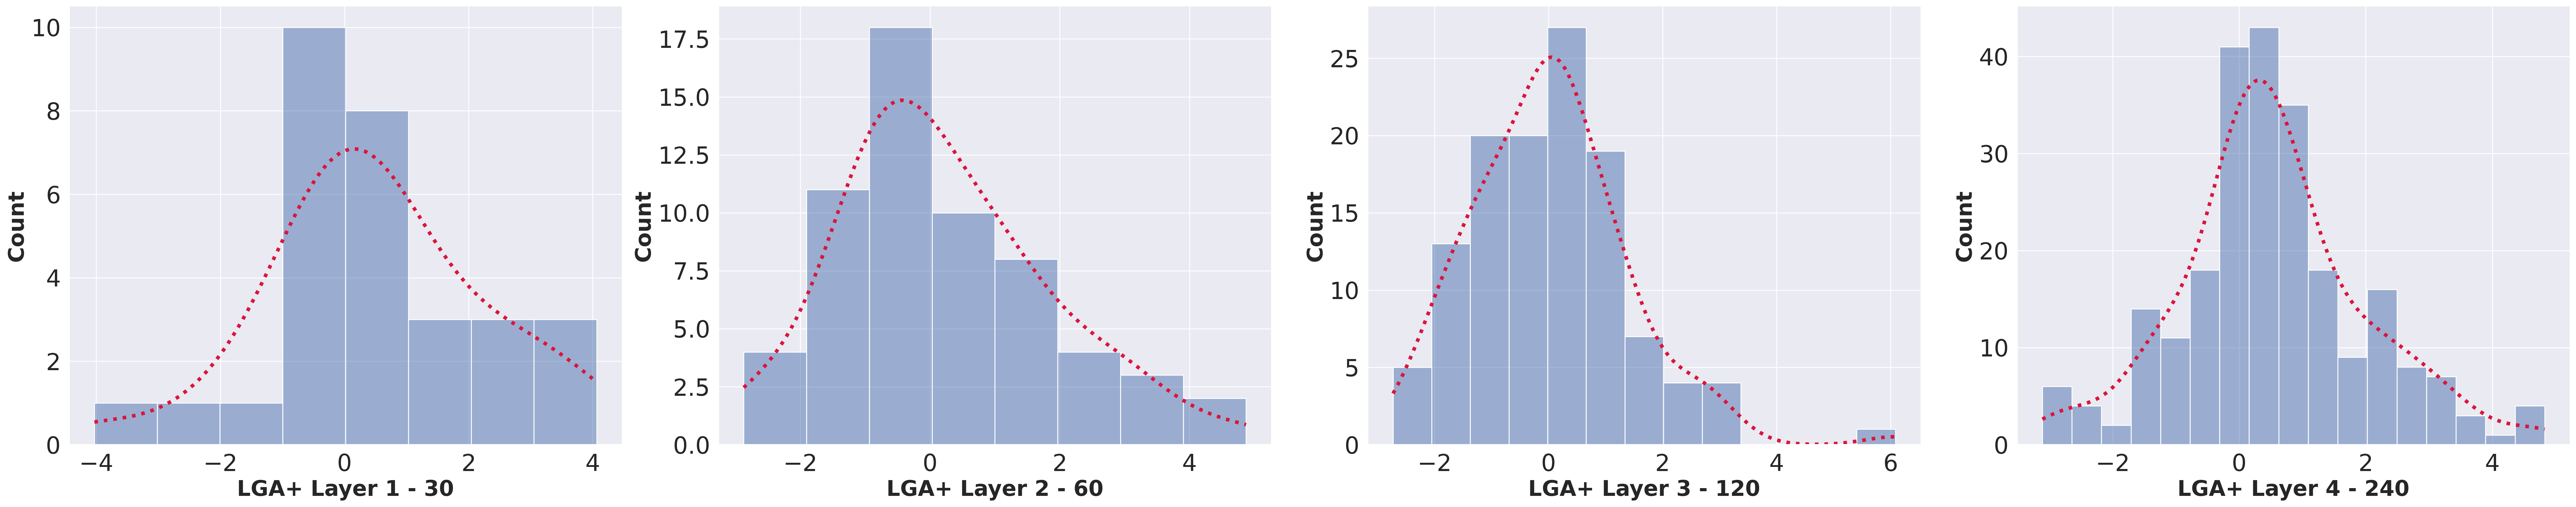

In [17]:

LGA_t = []

for name, param in model.named_parameters():
  if name in ['Enc.down_convs_local.0.gen_aggr.t',
              'Enc.down_convs_local.1.gen_aggr.t',
              'Enc.down_convs_local.2.gen_aggr.t',
              'Enc.down_convs_local.3.gen_aggr.t']:
    LGA_t.append(param.detach().cpu().numpy())
    

f, axes = plt.subplots(1, len(HGA_t), figsize=(40, 8))
layer = 1

for t, ax in zip(LGA_t, axes.flatten()):
    hist = sns.histplot(t.reshape(-1, 1), legend=False, ax=ax, kde=True, 
                        line_kws={'lw': 4, 'ls': ':'})
    hist.lines[0].set_color('crimson')
    hist.tick_params(labelsize=26)
    
    hist.set_xlabel(f'LGA+ Layer {layer} - {t.shape[0]}', weight='bold', fontsize=24)
    hist.set_ylabel('Count', weight='bold', fontsize=24)
    
    layer += 1
    
plt.tight_layout()

## Surface Area

In [18]:
import trimesh 
import torch

test_mask = [] 
face_areas = []

for idx, f in enumerate(bbw_set.mesh_list):
    plydata = trimesh.load(f, force="mesh")
    
    face_areas.append(torch.from_numpy(np.asarray(plydata.area_faces)))
    test_mask.append(bbw_set[idx].y.cpu().view(-1).long())
    
test_mask = torch.hstack(test_mask)
face_areas = torch.hstack(face_areas)

/tmp/ipykernel_118824/4080894136.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  face_areas.append(torch.from_numpy(np.asarray(plydata.area_faces)))


In [19]:
from torch_geometric.nn import aggr 

sum_aggr = aggr.SumAggregation()
area_per_mask = sum_aggr(face_areas.view(-1, 1), test_mask)

area_per_mask / area_per_mask.sum()

tensor([[0.8855],
        [0.1145]], dtype=torch.float64)

## FPS Pooling

In [20]:
import torch
from model.pool import RandomPooling, FPSPooling, EdgeRandomPooling

In [21]:
num_pool = 4
fps = FPSPooling()

p = bbw_set[idx].pos
y = bbw_set[idx].y
edge_index = bbw_set[idx].edge_index

batch = torch.zeros(p.shape[0], dtype=torch.long)
ptr = torch.Tensor([0, p.shape[0]]).long()

In [22]:
from torch_geometric.nn import radius_graph, knn_graph

p_down = [p]
y_down = [y]
edge_down = [edge_index]

for i in range(0, num_pool):    
    edge_index_pool, node_index, ptr_pool = fps(p, 
                                                edge_index, 
                                                3,
                                                ptr)
    p_pool = p[node_index]
    y_pool = y[node_index]
    
    p = p_pool
    y = y_pool
    edge_index = radius_graph(x=p[:,0:2], r= 0.05 * (i + 1), loop=False, max_num_neighbors=3, flow = 'target_to_source')
    ptr = ptr_pool
    
    p_down.append(p)
    y_down.append(y)
    edge_down.append(edge_index)

In [23]:
pool_idx = 3

p_pool = p_down[pool_idx].cpu().numpy()
y_pool = y_down[pool_idx].cpu().numpy()

edge_pool = edge_down[pool_idx].cpu().t().numpy()
edge_pool = np.hstack((np.full((edge_pool.shape[0], 1), 2), edge_pool), dtype=edge_pool.dtype)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


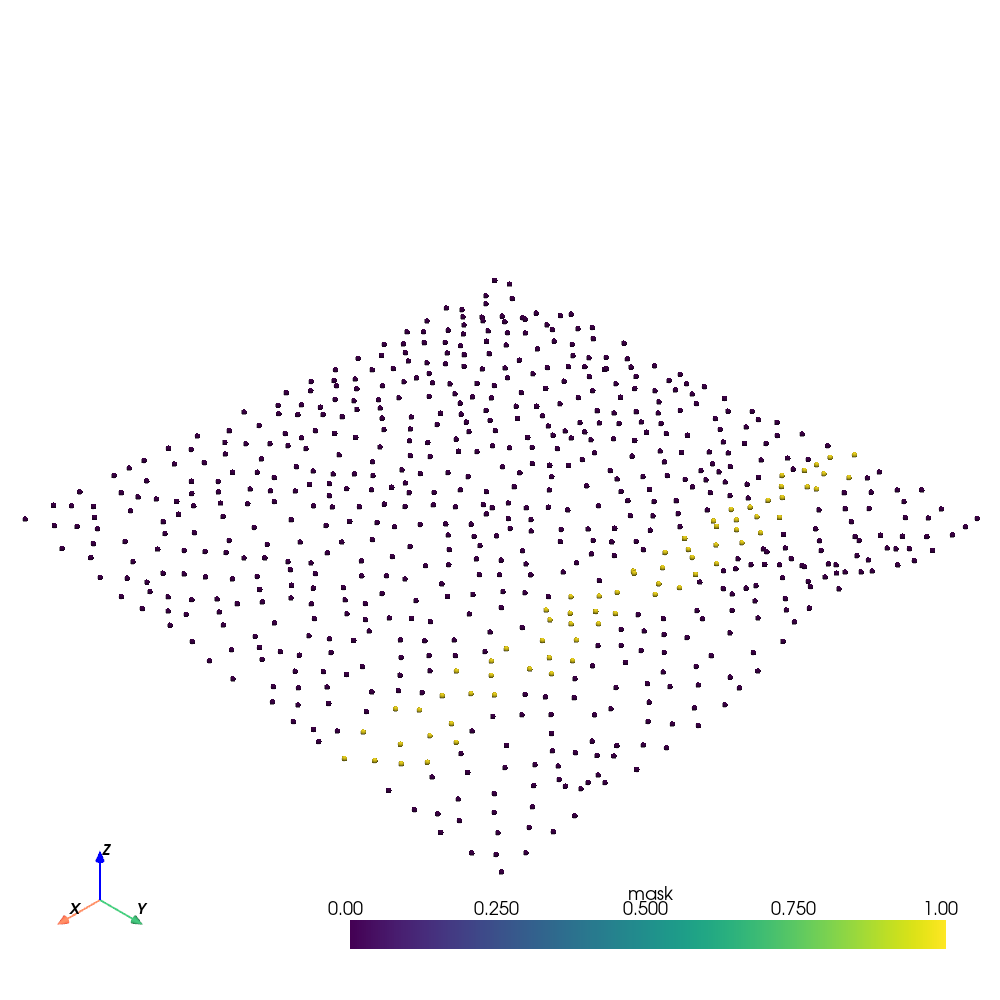

In [24]:
face_pcd = pv.PolyData(p_pool)

# face_pcd.lines = edge_pool
face_pcd.point_data['mask'] = y_pool
face_pcd.point_data.active_scalars_name = 'mask'
face_pcd.plot(scalars='mask', cmap='viridis', cpos='iso', window_size=w_size, render_points_as_spheres=True, point_size=6, line_width=1)

## Random Decimation

In [25]:
num_pool = 4
decimate = RandomPooling()

p = bbw_set[idx].pos
y = bbw_set[idx].y
edge_index = bbw_set[idx].edge_index

batch = torch.zeros(p.shape[0], dtype=torch.long)
ptr = torch.Tensor([0, p.shape[0]]).long()

In [26]:
from torch_geometric.nn import radius_graph, knn_graph
from torch_geometric.utils import coalesce, to_undirected

p_down = [p]
y_down = [y]
edge_down = [edge_index]

for i in range(0, num_pool):    
    edge_index_pool, node_index, ptr_pool = decimate(p[:,0:2], 
                                                     edge_index, 
                                                     3,
                                                     ptr)
    p_pool = p[node_index]
    y_pool = y[node_index]
    
    p = p_pool
    y = y_pool
    new_edge_index = radius_graph(x=p[:,0:2], 
                                  r= 0.05 * (i + 1), 
                                  loop=False, max_num_neighbors=3, 
                                  flow = 'target_to_source')
    edge_index = to_undirected(coalesce(torch.cat([new_edge_index, 
                                                   edge_index_pool], dim=-1)))
    ptr = ptr_pool
    
    p_down.append(p)
    y_down.append(y)
    edge_down.append(edge_index)

In [27]:
pool_idx = 3

p_pool = p_down[pool_idx].cpu().numpy()
y_pool = y_down[pool_idx].cpu().numpy()

edge_pool = edge_down[pool_idx].cpu().t().numpy()
edge_pool = np.hstack((np.full((edge_pool.shape[0], 1), 2), edge_pool), dtype=edge_pool.dtype)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


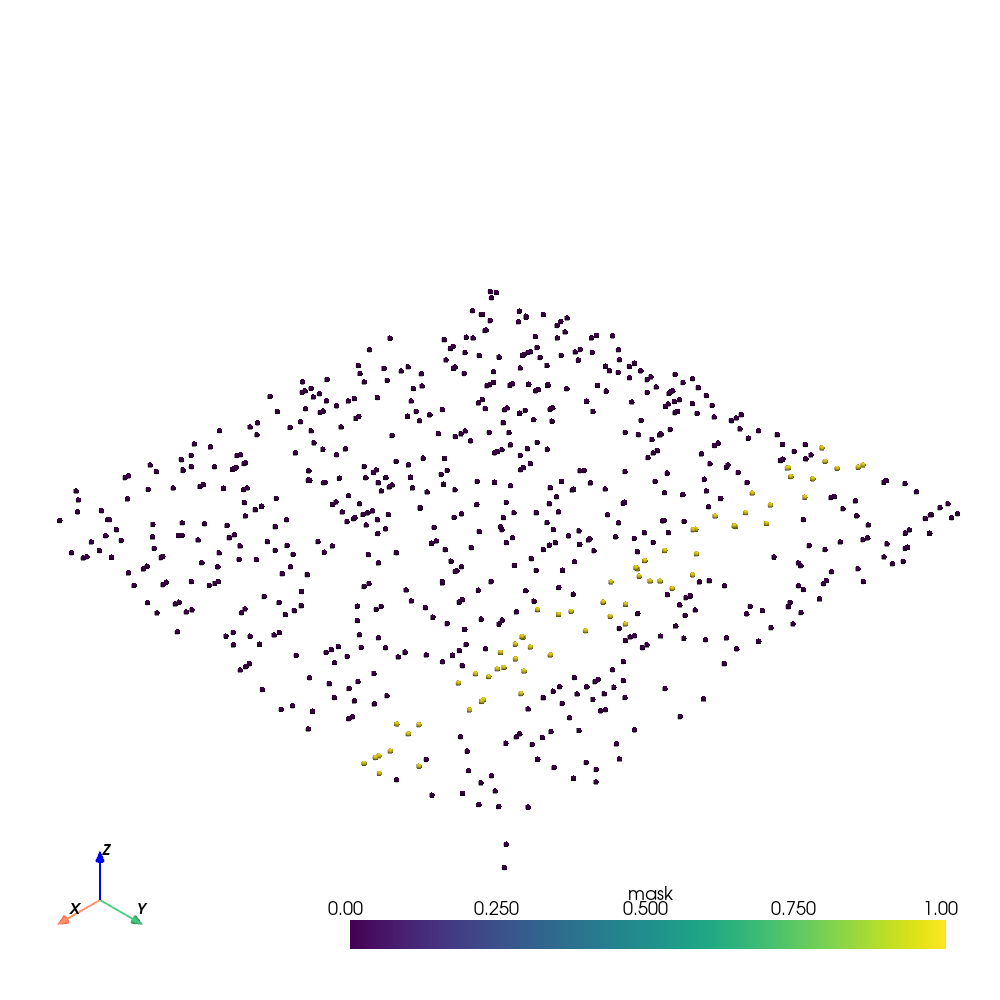

In [28]:
face_pcd = pv.PolyData(p_pool)

# face_pcd.lines = edge_pool
face_pcd.point_data['mask'] = y_pool
face_pcd.point_data.active_scalars_name = 'mask'
face_pcd.plot(scalars='mask', cmap='viridis', cpos='iso', window_size=w_size, render_points_as_spheres=True, point_size=6, line_width=1)

## Edge Decimation

In [29]:
num_pool = 4
edge_decimate = EdgeRandomPooling()

p = bbw_set[idx].pos
y = bbw_set[idx].y
edge_index = bbw_set[idx].edge_index

In [30]:

p_down = [p]
y_down = [y]
edge_down = [edge_index]
dropout_rate = [0.8, 0.75, 0.75, 0.5]

for i in range(0, num_pool):
    edge_index_pool, node_index = edge_decimate(p, edge_index)
    edge_decimate.dropout_rate = dropout_rate[i]
    
    p_pool = p[node_index]
    y_pool = y[node_index]
    
    p = p_pool
    y = y_pool
    edge_index = edge_index_pool
    
    p_down.append(p)
    y_down.append(y)
    edge_down.append(edge_index)

In [31]:
pool_idx = 3

p_pool = p_down[pool_idx].cpu().numpy()
y_pool = y_down[pool_idx].cpu().numpy()

edge_pool = edge_down[pool_idx].cpu().t().numpy()
edge_pool = np.hstack((np.full((edge_pool.shape[0], 1), 2), edge_pool), dtype=edge_pool.dtype)

/data/anaconda3/envs/gdl/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/data/anaconda3/envs/gdl/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


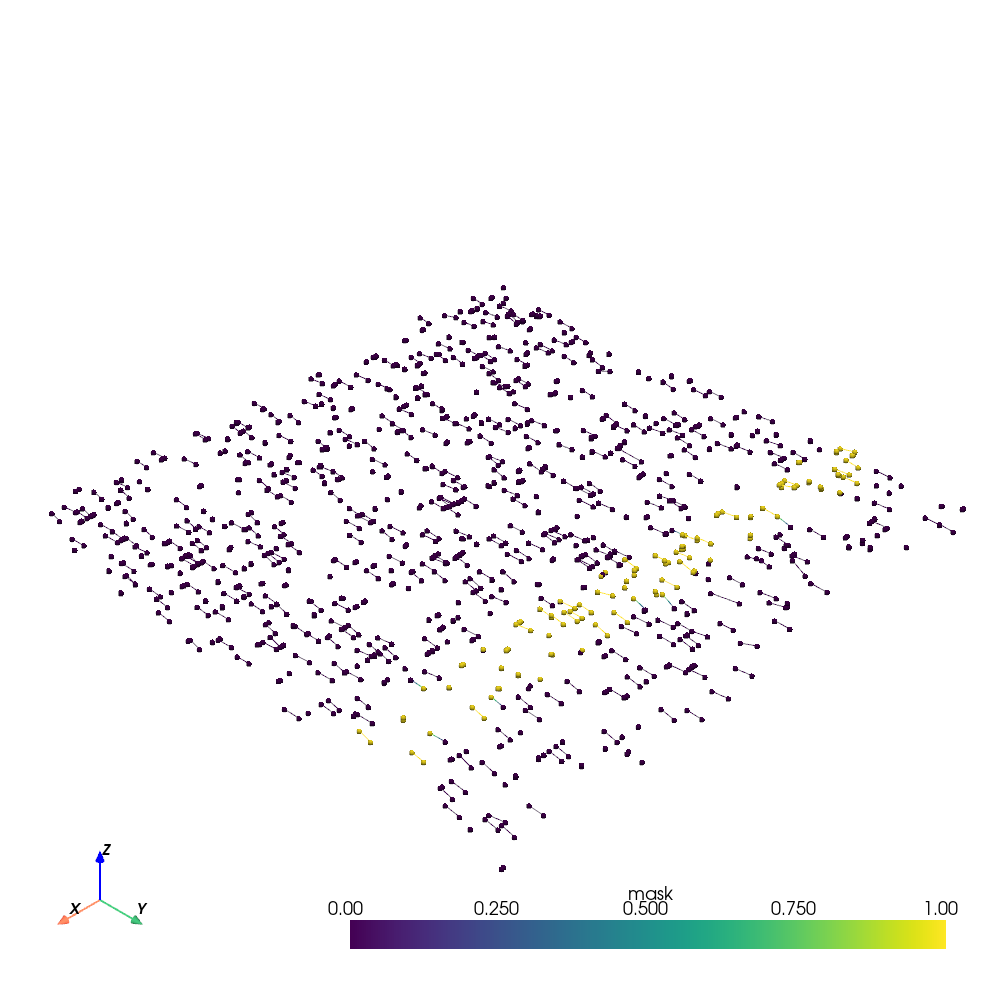

In [32]:
face_pcd = pv.PolyData(p_pool)

face_pcd.lines = edge_pool
face_pcd.point_data['mask'] = y_pool
face_pcd.point_data.active_scalars_name = 'mask'
face_pcd.plot(scalars='mask', cmap='viridis', cpos='iso', window_size=w_size, render_points_as_spheres=True, point_size=6, line_width=1)